$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\grad}[0]{\nabla}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\Var}[1]{\mathrm{Var}\left[#1\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[0]{\middle\vert}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\trace}{trace}
\newcommand{\1}[1]{\mathbb{I}\left\{#1\right\}}
\newcommand{\setof}[1]{\left\{#1\right\}}
\newcommand{\DO}[1]{\mathrm{do}\left(#1\right)}
\newcommand{\indep}{\perp \!\!\! \perp}
$$


# <center>Causal Inference 097400, Winter 2019-20<br><br>Final Project</center>

#### <center>Aviv Rosenberg<br>`avivr@cs`</center>

##### <center>April, 2020<br></center>


In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

DATA_FILE = 'data/nsr_chf_af_ag-y45o60-winfilt2.xlsx'
OUT_DIR = 'out/'

os.makedirs(OUT_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
plt.rcParams['font.size'] = 12

## Part 1: Exploring the data

In [3]:
from ciproj import data

dfs = data.load_mhrv_xls(DATA_FILE, sheet_names=['NSR', 'AGING'])

assert not np.any(np.isnan(dfs['NSR'].values))
assert not np.any(np.isnan(dfs['AGING'].values))

Loaded NSR: 3156 samples, 58 features
Loaded AGING: 5809 samples, 58 features


In [4]:
df_full = data.create_ci_dataset(df_control=dfs['NSR'], df_treated=dfs['AGING'])

We wish to assess the causal effect of age (the treatment variable) on several different possible outcome variables which are known to correspond to  heart-rate dynamics:

- The normalized power in the very-low frequency band.
- The DFA slopes, $\alpha_1$ and $\alpha_2$:
- The multiscale entropy.

For simplicity we make the treatment binary:
- $T=0$: Our control group consists of **healthy** individuals aged 22-45.
- $T=1$: Our treated group consists of **healthy** individuals aged 60 and over.

Note that we only use data from health individuals: no known underlying pardiopathologies, no arrhythmias in the processed ECG recordings. This is to ensure that if we measure the effect of age and not pathologies on the changes in HRV.

Let's plot the distribution of the data in the outcome variables of interest, conditioned on the treatment (young/old).

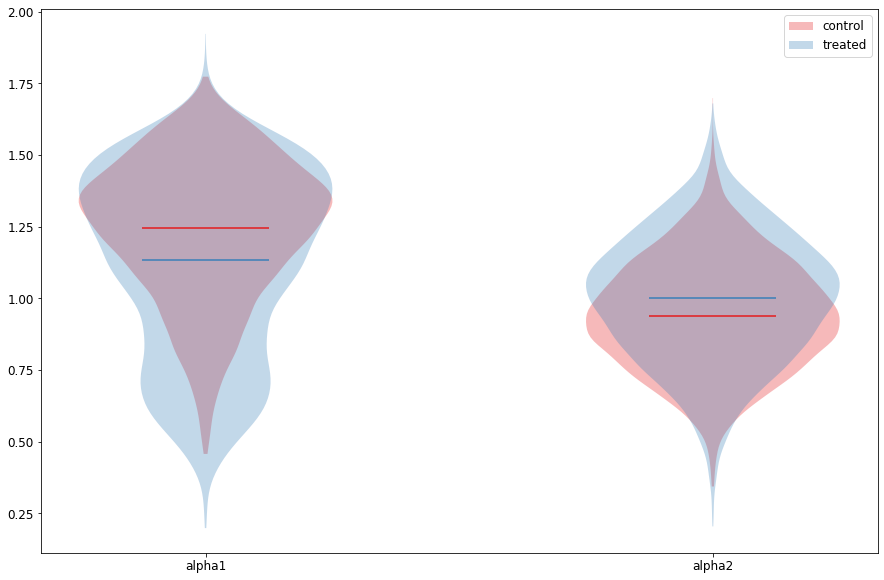

In [6]:
import ciproj.plot

fig, ax = plt.subplots(1, 1, figsize=(15,10))
group_by = dict(by='T')
group_legend_names={0:'control', 1:'treated'}
violin_args = dict(showextrema=False, showmeans=True, widths=0.5)
ciproj.plot.df_group_violins(ax, df_full, ['alpha1', 'alpha2'], group_by, violin_args, group_legend_names)

- The multiscale entropy:

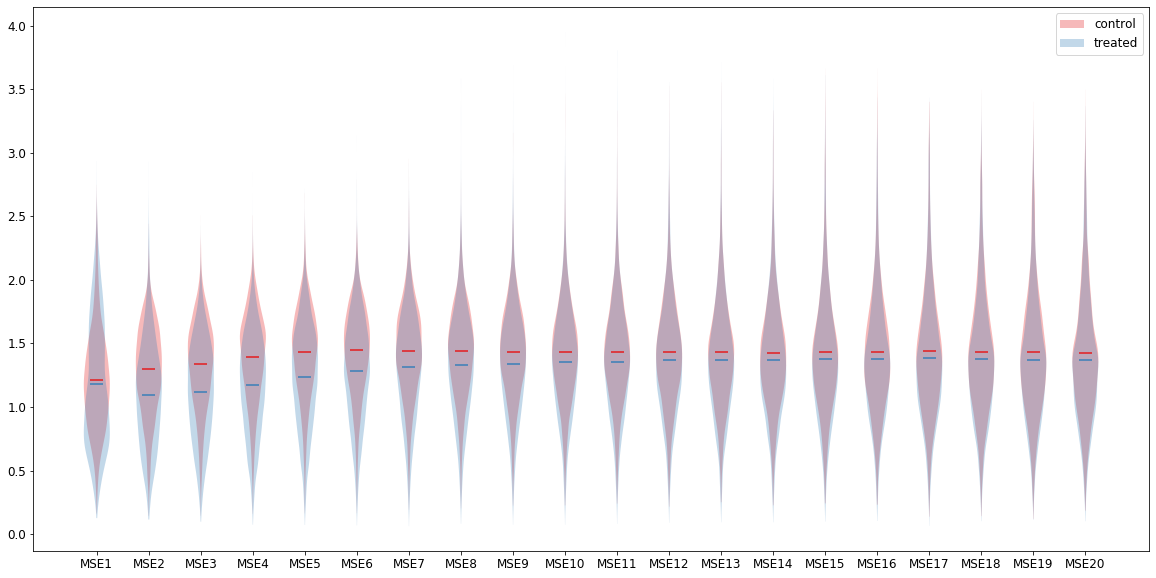

In [7]:
mse_vars = [f'MSE{i}' for i in range(1, 21)]
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ciproj.plot.df_group_violins(ax, df_full, mse_vars, group_by, violin_args, group_legend_names)

- The the power-spectral density within three different frequency bands:

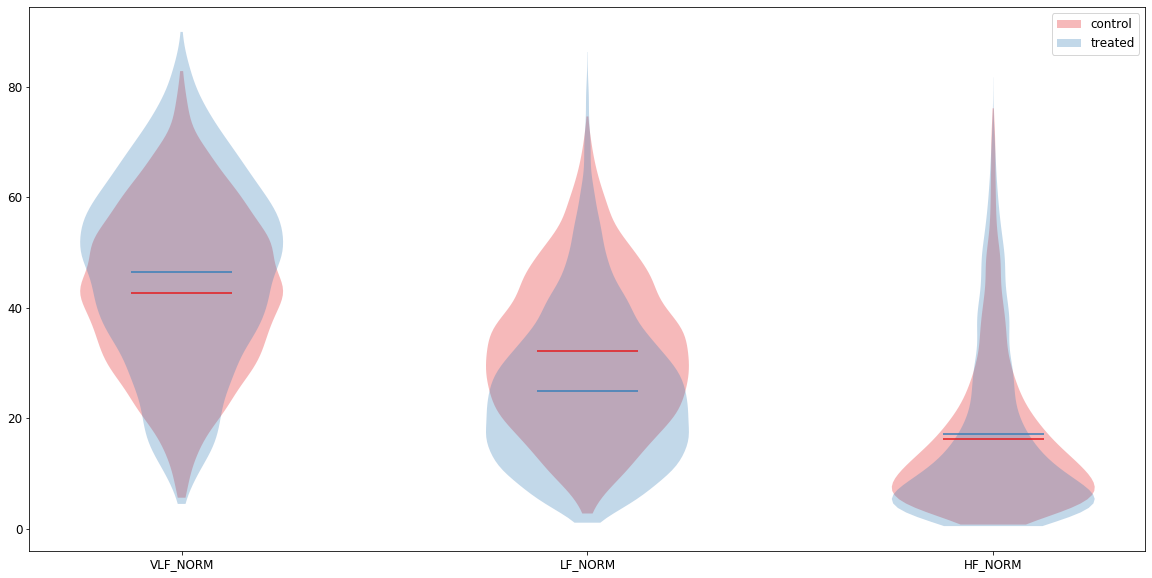

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ciproj.plot.df_group_violins(ax, df_full, ['VLF_NORM', 'LF_NORM', 'HF_NORM'], group_by, violin_args, group_legend_names)

We'll create three dataseats.
- The `vlf` dataset: Outcome is normalized VLF power. Regular VLF power will be removed from the covariates.
- The `dfa` dataset: Outcomes are `alpha1` and `alpha2` which are the DFA slopes.
- The `mse` dataset: Outcomes are `MSE1-20`, the multiscale entropy variables.

In [76]:
datasets = {}
datasets['vlf'] = ciproj.data.mark_dataset(df_full, outcomes=['VLF_NORM'], treatment='T', ignore=['VLF_POWER'])
datasets['dfa'] = ciproj.data.mark_dataset(df_full, outcomes=['alpha1', 'alpha2'], treatment='T')
datasets['mse'] = ciproj.data.mark_dataset(df_full, outcomes=mse_vars, treatment='T')

In [95]:
for name, df in datasets.items():
    print(f'*** {name} dataset: ', end='')
    X, y, y = ciproj.data.split_dataset(df, scale_covariates=True)
    print(f'X{X.shape}, y{y.shape}, t{t.shape}')
    print(f'covariates: {[x for x in df.columns if x.startswith("X_")]}')
    print(f'outcomes: {[x for x in df.columns if x.startswith("Y_")]}')
    print()

*** vlf dataset: X(8965, 45), y(8965,), t(8965,)
covariates: ['X_RR', 'X_NN', 'X_AVNN', 'X_SDNN', 'X_RMSSD', 'X_pNN50', 'X_SEM', 'X_BETA', 'X_HF_NORM', 'X_HF_PEAK', 'X_HF_POWER', 'X_LF_NORM', 'X_LF_PEAK', 'X_LF_POWER', 'X_LF_TO_HF', 'X_TOTAL_POWER', 'X_SD1', 'X_SD2', 'X_alpha1', 'X_alpha2', 'X_SampEn', 'X_MSE1', 'X_MSE2', 'X_MSE3', 'X_MSE4', 'X_MSE5', 'X_MSE6', 'X_MSE7', 'X_MSE8', 'X_MSE9', 'X_MSE10', 'X_MSE11', 'X_MSE12', 'X_MSE13', 'X_MSE14', 'X_MSE15', 'X_MSE16', 'X_MSE17', 'X_MSE18', 'X_MSE19', 'X_MSE20', 'X_PIP', 'X_IALS', 'X_PSS', 'X_PAS']
outcomes: ['Y_VLF_NORM']

*** dfa dataset: X(8965, 45), y(8965,), t(8965,)
covariates: ['X_RR', 'X_NN', 'X_AVNN', 'X_SDNN', 'X_RMSSD', 'X_pNN50', 'X_SEM', 'X_BETA', 'X_HF_NORM', 'X_HF_PEAK', 'X_HF_POWER', 'X_LF_NORM', 'X_LF_PEAK', 'X_LF_POWER', 'X_LF_TO_HF', 'X_TOTAL_POWER', 'X_VLF_NORM', 'X_VLF_POWER', 'X_SD1', 'X_SD2', 'X_SampEn', 'X_MSE1', 'X_MSE2', 'X_MSE3', 'X_MSE4', 'X_MSE5', 'X_MSE6', 'X_MSE7', 'X_MSE8', 'X_MSE9', 'X_MSE10', 'X_MSE11', '

## Part 2: Propensiy estimation and common support

The *propensity score* is defined as $e(\vec{x}):=\Pr{\left(\rvar{T}=1\given \rvec{X}=\vec{x}\right)}$.
In other words, it is the probability that a treatment $\rvar{T}=1$ will be assigned to a
unit with covariates $\rvec{X}=\vec{x}$.
In this case, since our treatment variable is age, it is not really "assigned" based on covariates.
However, the propensity estimation can shed light on whether covariates have predictive power regarding age, and help us achieve balanced covariate marginal distributions for matching.

We would like to obtain an estimator for the propensity score, $\hat e(\vec{x})$, from the data.
One important aspect of this estimator is that we would like it to be *calibrated*.
Briefly, this means that for if for example we look at all units $\vec{x}$ such that $e(\vec{x})=0.8$, we expect 80\% of them to actually belong to the treatment group ($\rvar{T}=1$).

((8965, 45), (8965,), (8965,))

In [46]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from scipy import stats

from ci.cv import CVConfig, LogSpaceSampler

# Define the methods and CV search space for propensity estimation
rcv_config = {
    'logistic': CVConfig(
        model=LogisticRegression(dual=False, solver='liblinear'),
        params=dict(C=LogSpaceSampler(-5, 2), penalty=['l1','l2']),
    ),
    'gbm': CVConfig(
        model=GradientBoostingClassifier(),
        params=dict(
            n_estimators=stats.randint(10, 100 + 1),
            max_depth=stats.randint(1, 3 + 1),
            learning_rate=LogSpaceSampler(-2, 0.5),
        )
    ),
}

vlf logistic 	best_params={'model__C': 53.48157277815876, 'model__penalty': 'l1'}
dfa logistic 	best_params={'model__C': 48.2159531025672, 'model__penalty': 'l1'}
mse logistic 	best_params={'model__C': 74.7465888417509, 'model__penalty': 'l1'}
vlf gbm 	best_params={'model__learning_rate': 0.25299303475568624, 'model__max_depth': 3, 'model__n_estimators': 56}
dfa gbm 	best_params={'model__learning_rate': 0.22537489152910667, 'model__max_depth': 3, 'model__n_estimators': 85}
mse gbm 	best_params={'model__learning_rate': 0.41307261690155245, 'model__max_depth': 3, 'model__n_estimators': 82}


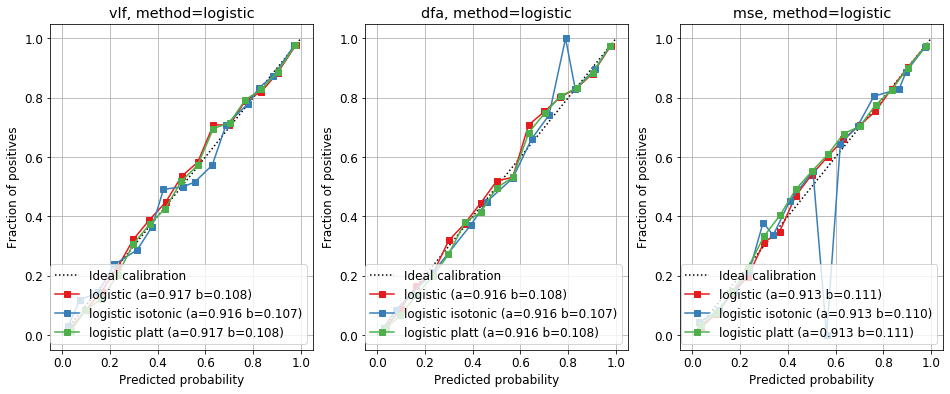

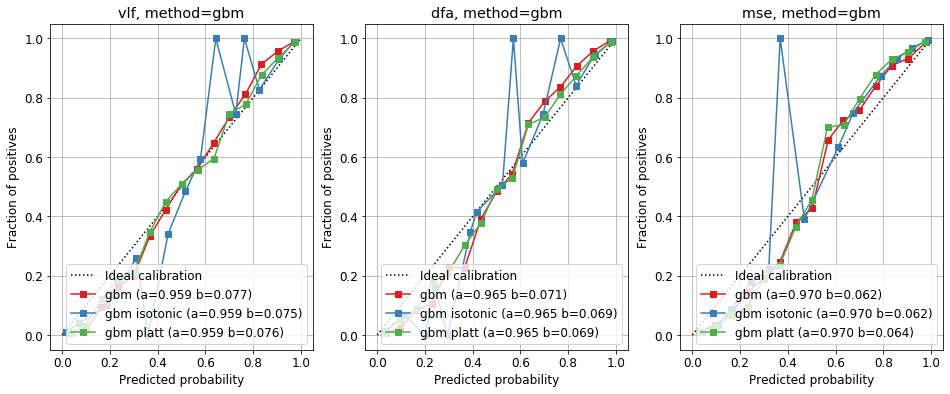

In [84]:
from ci.propensity import fit_propensity_cv

# Create a dataframe to store propensities from each dataset and each method
midx = pd.MultiIndex.from_product([datasets.keys(), rcv_config.keys()], names=['dataset', 'method'])
df_propensity = pd.DataFrame(columns=midx)

for method, cv_cfg in rcv_config.items():
    fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(16, 6))
    
    for i, (dataset_name, df) in enumerate(datasets.items()):
        # Get covariates X and treatment assignment t as numpy arrays
        X, _, t = ciproj.data.split_dataset(df, scale_covariates=True)
        
        # Train a model to estimate propensity using current method,
        # calibrate with two approaches and generate a calibration plot
        model, best_params = fit_propensity_cv(
            cv_cfg, X, t, plot_args=dict(name=method, ax=ax[i]),
            test_size=0.3, n_iter=42, random_state=42+i, cv_splits=4
        )
        
        # Use the best calibrated model (lowest Brier score) to estimate the propensities
        prop = model.predict_proba(X)[:, 1]
        df_propensity[(dataset_name, method)] = prop
        
        ax[i].set_title(f'{dataset_name}, method={method}')
        print(f'{dataset_name} {method} \tbest_params={best_params}')

The plots above show the calibration curves of the logistic regression (top row) and the GBM models (middle row).
The ideal calibration is shown as a dotted line.
For each classifier, two calibration methods, Platt and Isotonic Regression, are shown.
In the legend, both the ROC-AUC score (`a`) and the Brier score (`b`) are reported as measures of the model's
classification performance (higher is better) and de-calibration level (lower is better), respectively.

In [85]:
df_propensity.head()

dataset       vlf                 dfa                 mse          
method   logistic       gbm  logistic       gbm  logistic       gbm
0        0.281707  0.240540  0.250059  0.262293  0.292224  0.115000
1        0.322386  0.672742  0.359261  0.403333  0.575072  0.382272
2        0.315838  0.405985  0.411441  0.473828  0.390089  0.451107
3        0.224100  0.229105  0.207083  0.228666  0.210264  0.103946
4        0.226075  0.070866  0.302321  0.084412  0.113702  0.099289

To visualize the propensity estimation results of each method, we can plot the distribution of propensity scores between treated and control groups.

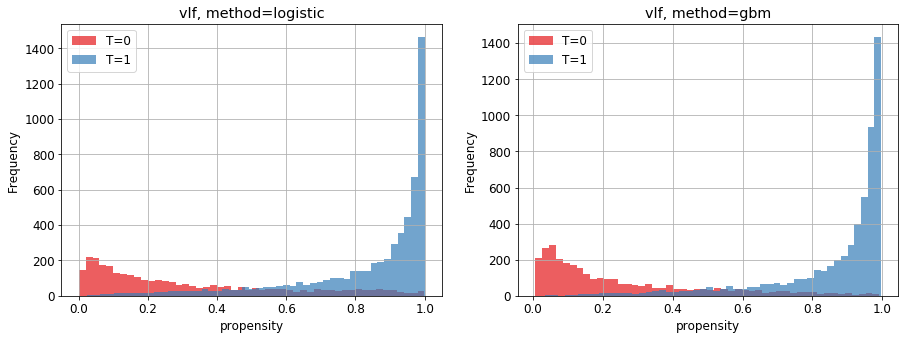

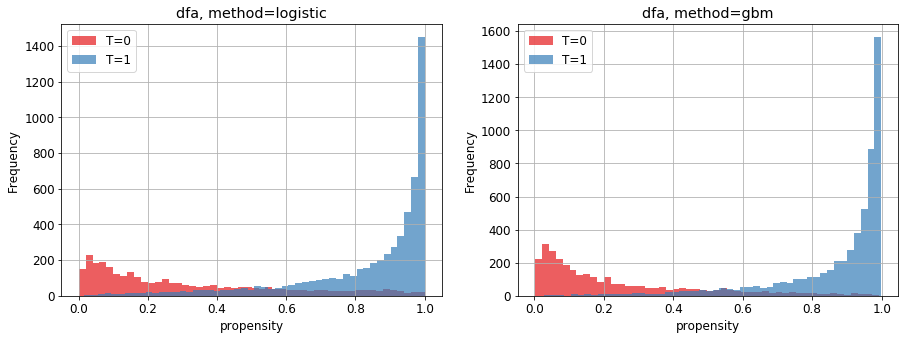

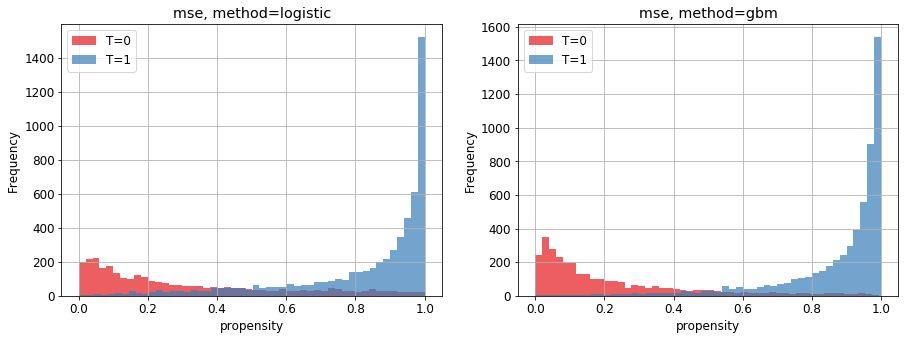

In [97]:
for i, (dataset_name, df) in enumerate(datasets.items()):
    fig, ax = plt.subplots(nrows=1, ncols=len(rcv_config.keys()), figsize=(15, 5))
    # Create a temporaty dataframe
    df_tmp = df.copy()
    
    for j, method in enumerate(rcv_config.keys()):
        # Add propensity from current method to the temporary dataframe
        df_tmp['propensity'] = df_propensity[(dataset_name, method)].values
        # Plot propensity scores conditioned on treatment
        groups = df_tmp.groupby('T')
        groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=50, ax=ax[j])
        ax[j].set_title(f'{dataset_name}, method={method}')
        ax[j].set_xlabel('propensity'); ax[j].grid(True); ax[j].legend([f'T=0','T=1'])

In order to do causal inference we need the common support ("overlap") assumption to hold:
$$
\forall t,~\vec{x}:\ \Pr\left(\rvar{T}=t\given \rvec{X}=\vec{x}\right)>0.
$$
This means that the the probability of any treatment is possible for any possible covariates of a unit.
In practice we have a limited dataset, and in our specific data this assumption does not hold when
we don't have samples from both groups (treatment and control) within the entire range of propensity scores.
Therefore, to maintain the overlap assumption in our dataset, we'll remove samples for which the propensity
score is outside the range of propensity scores of the other group.
In addition, we'll remove samples with extremely low propensity and high scores as these will cause numerical errors.

The common support calculation is implemented in the `common_support` function within the `propensity.py` module.

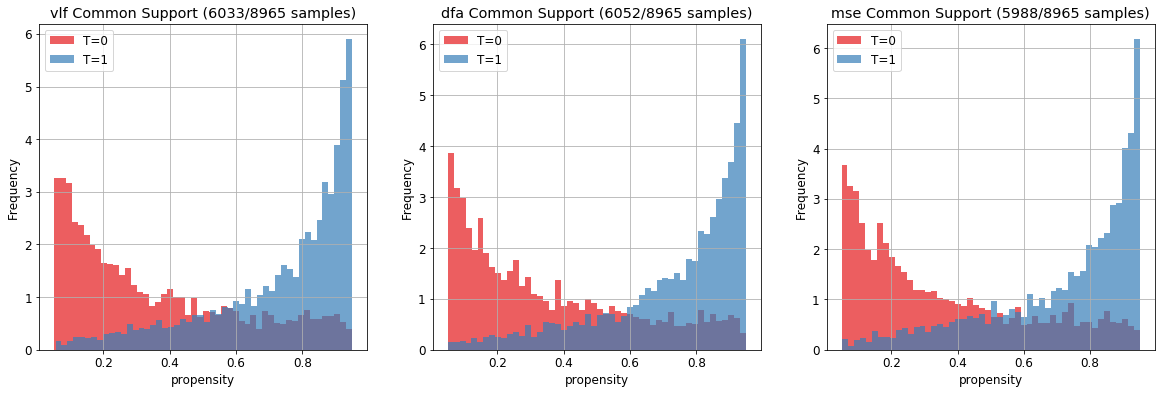

In [105]:
from ci.propensity import common_support

# Select 'logistic' as the propensity method for all datasets
prop_methods = ('logistic', 'logistic', 'logistic')
cs_threshold = 5e-2 # 5%/95%

# We'll save the dataframes after removing samples outside common support
datasets_cs = {}

fig, ax = plt.subplots(nrows=1, ncols=len(dataframes), figsize=(20, 6))
for i, (dataset_name, df) in enumerate(datasets.items()):
    # Copy the dataset and add a propesity column based on the selected method
    df = df.copy()
    df['propensity'] = df_propensity[(dataset_name, prop_methods[i])].values
    
    # Get common support indices and remove outlying samples
    idx_common = common_support(df['T'].to_numpy(), df['propensity'].to_numpy(),
                                min_thresh=cs_threshold, max_thresh=1-cs_threshold)
    df = df[idx_common]
    
    # Save the df with removed samples
    datasets_cs[dataset_name] = df
    
    groups = df.groupby('T')
    groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=50, ax=ax[i], density=True)
    ax[i].set_xlabel('propensity'); ax[i].grid(True); ax[i].legend([f'T=0','T=1'])
    ax[i].set_title(f'{dataset_name} Common Support ({len(df)}/{len(datasets[dataset_name])} samples)')
    

In [104]:
datasets_cs['mse']

,X_RR,X_NN,X_AVNN,X_SDNN,X_RMSSD,X_pNN50,X_SEM,X_BETA,X_HF_NORM,X_HF_PEAK,...,Y_MSE13,Y_MSE14,Y_MSE15,Y_MSE16,Y_MSE17,Y_MSE18,Y_MSE19,Y_MSE20,T,propensity
Row,,,,,,,,,,,,,,,,,,,,,
nsr047_1,872,869,661.059753,47.829563,19.061163,1.843318,1.622507,0.126201,9.502737,0.304977,...,2.001480,1.408767,1.185624,3.258096,1.845827,2.442347,1.446919,2.079442,0,0.292224
nsr047_2,872,869,674.185486,38.503155,17.583624,1.036866,1.306130,-0.127805,6.397126,0.365523,...,1.263692,1.481605,1.413693,1.734601,1.446919,1.349927,1.386294,1.003302,0,0.575072
nsr047_3,857,857,699.706482,55.378662,19.560434,1.285047,1.891699,-0.604867,8.341562,0.159216,...,1.209838,1.290984,1.694596,1.354546,1.321756,0.998529,1.386294,0.980829,0,0.390089
nsr047_4,929,928,643.167419,79.910538,19.377684,1.510248,2.623192,-0.604719,5.665492,0.353564,...,1.066864,1.519826,1.966113,1.405343,1.145132,0.916291,1.203973,0.971861,0,0.210264
nsr047_5,929,929,645.460510,71.772980,19.338352,1.508621,2.354795,-1.708907,4.419215,0.372251,...,0.958850,1.098612,1.049822,1.163151,1.252763,1.203973,1.157453,0.864997,0,0.113702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nsr046_123,687,687,872.634644,40.321175,37.290100,14.285714,1.538349,-1.369369,23.901632,0.347584,...,1.838279,1.172720,1.504077,1.824549,2.233592,1.413693,0.995428,1.540445,1,0.947977
nsr046_124,685,685,874.600830,53.427364,46.515739,21.491228,2.041355,-0.934699,17.293703,0.339361,...,1.033015,1.558145,1.516348,1.358124,1.193923,1.481605,1.299283,1.021651,1,0.912026
nsr046_125,669,669,894.618835,54.871948,44.956692,22.155689,2.121472,-0.583862,18.925045,0.352069,...,1.791759,1.704748,1.575536,1.609438,2.833213,1.343735,1.280934,1.871802,1,0.828573
